### HBAI vs inflation 
In this notebook we examine how HBAI low income groups changes with inflation.

We use CPI (https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/d7g7/mm23) as inflation data for our analysis. 

HBAI (Households below average income ) -relative low income if their net household income is below a threshold set at 60% of median income.

Income includes :
- Earnings from Employment (Wages, Self-Employment Income, Pandemic Support Schemes)
- Benefits and Tax Credits: Cash Benefits, Tax Credits
- Pension Payments: State Pension payments for retirees.
- Cost of Living Payments
- Income from Savings and Investments
- Rental Income: Income from renting out property, after expenses but before taxes.
- Private Pensions and Annuities
- Child Maintenance Payments: Regular payments received for child support.



   Year  CPI Annual Rate
0  1989              5.2
1  1990              7.0
2  1991              7.5
3  1992              4.2
4  1993              2.5
               Year Not in low income (at or above threshold)  \
0  1994-95 (cpi, r)                                  41860257   
1  1995-96 (cpi, r)                                  42023965   
2  1996-97 (cpi, r)                                  41617343   
3  1997-98 (cpi, r)                                  42173959   
4  1998-99 (cpi, r)                                  42284577   

  In low income (below threshold)     Total  
0                        13473772  55334029  
1                        13452053  55476018  
2                        13974044  55591387  
3                        13545932  55719891  
4                        13582259  55866836  
Rows to be removed:
                   Year Not in low income (at or above threshold)  \
26  2020-21 (covid2021)                                        ..   

   In low income (below 


Merged Data Summary:
              Year  CPI Annual Rate  Percent in low income
count    29.000000        29.000000              29.000000
mean   2009.103448         2.427586              22.245069
std       8.682268         1.868326               1.260447
min    1995.000000         0.000000              20.440977
25%    2002.000000         1.300000              21.336580
50%    2009.000000         2.200000              22.032465
75%    2016.000000         2.600000              22.649352
max    2024.000000         9.100000              25.137067


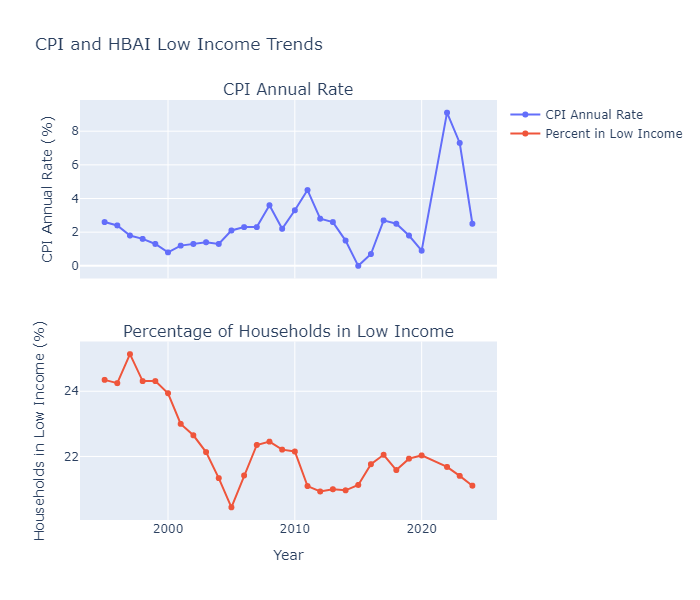

In [25]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np


def extract_and_fix_year(year_range):
    try:
        year_suffix = year_range.split('-')[1]
        full_year = "20" + year_suffix  if int(year_suffix) < 50 else "19" +year_suffix
        return int(full_year) 
    except:
        return None


# Hypothetical CPI data 
cpi_data =pd.read_csv("./inflation/series-230425_cleaned.csv")

hbai_data=pd.read_csv("./inflation/table_2025-05-12_12-08-26.csv")

cpi_data=cpi_data.rename(columns={"Title":"Year","CPI ANNUAL RATE 00: ALL ITEMS 2015=100":"CPI Annual Rate"})


print(cpi_data.head(5))
print(hbai_data.head(5))


# Display rows that will be removed
rows_to_remove = hbai_data[hbai_data.isin(['..']).any(axis=1)]

print("Rows to be removed:")
print(rows_to_remove)

# Replace '..' with NaN
hbai_data.replace('..', pd.NA, inplace=True)


# Drop rows with NaN values in specified columns
hbai_data.dropna(inplace=True)


hbai_data['Year'] = hbai_data['Year'].str.extract(r'(\d{4}-\d{2})')
hbai_data['Year'] = hbai_data['Year'].apply(extract_and_fix_year)

hbai_data["In low income (below threshold)"]=pd.to_numeric(hbai_data["In low income (below threshold)"]) 
hbai_data["Total"]=pd.to_numeric(hbai_data["Total"]) 


# Calculate percentage of households in low income
hbai_data["Percent in low income"] = (hbai_data["In low income (below threshold)"] / hbai_data["Total"]) * 100


# Merge datasets on Year
merged_df = pd.merge(cpi_data, hbai_data[["Year", "Percent in low income"]], on="Year", how="inner")

# Analyze correlation
correlation = merged_df["CPI Annual Rate"].corr(merged_df["Percent in low income"])
print(f"Correlation between CPI Annual Rate and Percent in Low Income: {correlation:.3f}")

# Create subplots for visualization
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=("CPI Annual Rate", "Percentage of Households in Low Income"),
    shared_xaxes=True,
    vertical_spacing=0.15
)

# Plot CPI data
fig.add_trace(
    go.Scatter(x=merged_df["Year"], y=merged_df["CPI Annual Rate"], mode="lines+markers", name="CPI Annual Rate"),
    row=1, col=1
)

# Plot HBAI low-income percentage
fig.add_trace(
    go.Scatter(x=merged_df["Year"], y=merged_df["Percent in low income"], mode="lines+markers", name="Percent in Low Income"),
    row=2, col=1
)

# Update layout
fig.update_layout(
    title_text="CPI and HBAI Low Income Trends ",
    height=600,
    showlegend=True
)
fig.update_xaxes(title_text="Year", row=2, col=1)
fig.update_yaxes(title_text="CPI Annual Rate (%)", row=1, col=1)
fig.update_yaxes(title_text="Households in Low Income (%)", row=2, col=1)

# Show plot
fig.show()

# Scatter plot to visualize relationship
fig_scatter = px.scatter(
    merged_df,
    x="CPI Annual Rate",
    y="Percent in low income",
    text="Year",
    title="CPI Annual Rate vs. Percent in Low Income ",
    labels={"CPI_Annual_Rate": "CPI Annual Rate (%)", "Percent in low income": "Households in Low Income (%)"}
)
fig_scatter.update_traces(textposition="top center")
fig_scatter.show()

# Summary statistics
print("\nMerged Data Summary:")
print(merged_df.describe())

import plotly.io as pio
pio.write_image(fig, 'chart.png')  # Save the figure as an image

from IPython.display import display, Image
display(Image(filename='chart.png'))

### Observations
Correlation of CPI and percentage of low income (HBAI after housing costs) appears to be weak.

Below we try to see if there is any lag between the correlation of the two. 

Lag Correlation Results:
   Lag  Correlation
0    0    -0.205961
1    1    -0.155094
2    2    -0.184948
3    3    -0.266017
4    4    -0.242784
5    5    -0.280343


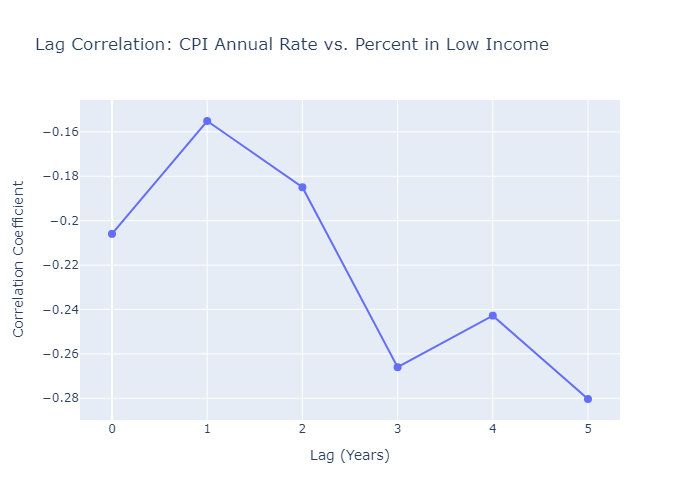


Strongest Correlation: Lag 5 years, Correlation = -0.280


In [24]:

# Define maximum lag to test (e.g., 5 years)
max_lag = 5
lags = range(max_lag + 1)
correlations = []

df= merged_df.copy()
# Calculate correlation for each lag
for lag in lags:
    # Shift the low-income percentage by 'lag' years
    df[f"Percent in low income lag {lag}"] = df["Percent in low income"].shift(lag)
    # Calculate correlation between CPI and the lagged low-income percentage
    correlation = df["CPI Annual Rate"].corr(df[f"Percent in low income lag {lag}"])
    correlations.append(correlation)

# Create DataFrame for correlations
lag_corr_df = pd.DataFrame({
    "Lag": lags,
    "Correlation": correlations
})

# Display correlations
print("Lag Correlation Results:")
print(lag_corr_df)

# Visualize the correlations
fig = px.line(
    lag_corr_df,
    x="Lag",
    y="Correlation",
    markers=True,
    title="Lag Correlation: CPI Annual Rate vs. Percent in Low Income",
    labels={"Lag": "Lag (Years)", "Correlation": "Correlation Coefficient"}
)
fig.update_traces(line=dict(width=2), marker=dict(size=8))
fig.show()

pio.write_image(fig, 'chart_lag.png')  # Save the figure as an image

display(Image(filename='chart_lag.png'))

# Find the lag with the strongest correlation (absolute value)
strongest_lag = lag_corr_df.iloc[lag_corr_df["Correlation"].abs().idxmax()]
print(f"\nStrongest Correlation: Lag {int(strongest_lag['Lag'])} years, Correlation = {strongest_lag['Correlation']:.3f}")

### Observations
The correlation between the two is still weak even with delays.  A higher inflation does not imply more lower income families.
However, logically we would agree that higher inflation would negatively affect lower income family.  Normally inflation on necessities like food, gas, and rent are  higher than that of other CPI components (e.g. TVs, electronics, apparel).  This means impacts on lower income families would be worse then higher income family.
